In [23]:
import os, pandas as pd
from sqlalchemy import create_engine, Column, MetaData, text
import getpass,time

In [24]:
user = getpass.getpass()
password = getpass.getpass()

········
········


In [25]:
def mysql_query(query,user=user, password=password, host='jarvis.workisboring.com', port=9030):
    # check if port is in 9030, 19030, or 3306, 9005
    # start time
    start_time = time.time()
    
    if port in [9030, 19030, 3306,9004]:
        engine = create_engine('mysql+pymysql://'+user+':'+password+'@'+host+':'+str(port))
        #df = pd.read_sql(query, engine)
        df = pd.read_sql_query(sql=text(query), con=engine.connect())
        # end time
        end_time = time.time()
        # seconds
        elapsed_time = end_time - start_time
        print(f'Elapsed time: {elapsed_time} seconds')
        return df    
    else:
        print('port is not in 9030, 19030, or 3306, please check')
        return None

# Q.2

### How many observations does crsp.dsf have? How many columns?

In [43]:
# Number of observations
query = 'select count(*) as observations from crsp.dsf'
dsf_obs = mysql_query(query,user=user,password=password,port=19030) # Apache Doris
dsf_obs

Elapsed time: 0.3326866626739502 seconds


,observations
0,102905313


In [44]:
# Number of columns
query = "SELECT COUNT(*) as column_num FROM information_schema.columns WHERE table_name = 'dsf';"
mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 3.183823823928833 seconds


,column_num
0,20


### What is the unit of observation?

In [45]:
# Find column names from crsp.dsf
query = 'SELECT column_name FROM information_schema.columns WHERE table_name = "dsf";'
dsf_columns = mysql_query(query,user=user,password=password,port=19030) # Apache Doris
dsf_columns

Elapsed time: 3.0757153034210205 seconds


,column_name
0,permno
1,date
2,cusip
3,permco
4,issuno
5,hexcd
6,hsiccd
7,bidlo
8,askhi
9,prc


In [46]:
# Find column names from crsp.dsenames
query = 'SELECT column_name FROM information_schema.columns WHERE table_name = "dsenames";'
dsenames_columns = mysql_query(query,user=user,password=password,port=19030) # Apache Doris
dsenames_columns

Elapsed time: 2.9944143295288086 seconds


,column_name
0,permno
1,namedt
2,nameendt
3,shrcd
4,exchcd
5,siccd
6,ncusip
7,ticker
8,comnam
9,shrcls


# Join tables dsf and dsenames

In [47]:
query = """select count(*)
           from 
              crsp.dsf as a 
              inner join 
              crsp.dsenames as b 
              using (cusip, permno, permco, hexcd, hsiccd, issuno)
           where b.shrcd in (10,11);"""
rows = mysql_query(query,user=user,password=password,port=19030) # Apache Doris
rows

Elapsed time: 0.18428826332092285 seconds


,count(*)
0,340722893


### What are the beginning and end of the sample? (Use joined table of dsf and dsenames)

#### Beginning of sample

In [48]:
query = """select * 
           from 
              crsp.dsf as a
              inner join
              crsp.dsenames as b
              using (cusip, permno, permco, hexcd, hsiccd, issuno)
           where b.shrcd in (10,11)
           limit 1;"""
mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 0.14819765090942383 seconds


,permno,date,cusip,permco,issuno,hexcd,hsiccd,bidlo,askhi,prc,...,trdstat,secstat,permco,compno,issuno,hexcd,hsiccd,cusip,start,end
0,10000,1986-01-23,68391610,7952.0,10396.0,3.0,3990.0,3.625,3.875,-3.75,...,A,R,7952.0,60007905.0,10396.0,3.0,3990.0,68391610,1987-03-10,1987-06-11


#### End of sample

In [49]:
query = """select * 
           from 
              crsp.dsf as a 
              inner join 
              crsp.dsenames as b 
              using (cusip, permno, permco, hexcd, hsiccd, issuno) 
           where b.shrcd in (10,11)
           limit %s, 1;""" % (rows.iloc[0, 0] -1)
mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 0.11193156242370605 seconds


,permno,date,cusip,permco,issuno,hexcd,hsiccd,bidlo,askhi,prc,...,trdstat,secstat,permco,compno,issuno,hexcd,hsiccd,cusip,start,end
0,93405,2010-06-30,16890G20,53431.0,0.0,2.0,3674.0,2.81,2.95,2.87,...,A,R,53431.0,0.0,0.0,2.0,3674.0,16890G20,2010-06-18,2011-03-24


### How many distinct dates are there? How many distinct stocks are there?

#### Number of distinct dates in joined table

In [50]:
query = """SELECT 
              COUNT(DISTINCT DATE) AS "number of distinct dates" 
           FROM 
              crsp.dsf as a 
              inner join 
              (select * from crsp.dsenames where shrcd in (10, 11)) as b 
              using (cusip, permno, permco, hexcd, hsiccd, issuno);"""
mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 0.12614846229553223 seconds


,number of distinct dates
0,25549


#### Number of distinct stocks in joined table

In [15]:
query = """SELECT 
              count(distinct a.permno) as "number of distinct stocks" 
           FROM 
              crsp.dsf as a 
              inner join 
              (select * from crsp.dsenames where shrcd in (10, 11)) as b 
              on (a.cusip=b.cusip and a.permno=b.permno 
                  and a.permco=b.permco 
                  and a.hexcd=b.hexcd 
                  and a.hsiccd=b.hsiccd 
                  and a.issuno=b.issuno);"""
mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 7.298705339431763 seconds


,number of distinct stocks
0,20868


### Find the biggest movers (largest price movement) on the latest trading data for the last day of 2022 (Use "order by")

### Find top 10 stocks with maximum price range in year 2022

#### Approach 1: ORDER BY approach

In [44]:
query = """SELECT 
              permno, 
              MAX(prc) - MIN(prc) AS prc_range 
           FROM 
              crsp.dsf
           WHERE DATE LIKE "2022%" GROUP BY permno ORDER BY prc_range DESC LIMIT 10;"""
mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 0.11397457122802734 seconds


,permno,prc_range
0,17778,140052.250000
1,84788,3326.270088
2,14542,2877.239983
3,90319,2876.570000
4,79785,2149.680176
5,20391,1715.820068
6,23204,1669.000000
7,17677,1610.979980
8,61508,1417.044983
9,15358,1337.470015


#### Approach 2: SUBQUERY approach

In [45]:
query = """SELECT 
              permno, 
              MAX(prc) - MIN(prc) AS prc_range 
           FROM 
              crsp.dsf 
           where 
              date IN (SELECT date FROM crsp.dsf WHERE DATE LIKE "2022%")
           GROUP BY permno 
           ORDER BY prc_range DESC 
           LIMIT 10;"""
mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 0.09200048446655273 seconds


,permno,prc_range
0,17778,140052.250000
1,84788,3326.270088
2,14542,2877.239983
3,90319,2876.570000
4,79785,2149.680176
5,20391,1715.820068
6,23204,1669.000000
7,17677,1610.979980
8,61508,1417.044983
9,15358,1337.470015


# Bonus (3 points): Follow the portfolio sort methodology to divide, every month, stocks into deciles based on the Amihud illiquidity factor

In [18]:
query = """SELECT
              `date`,
              ceiling(10 * ROW_NUMBER() OVER (PARTITION BY `year_month` ORDER BY `signal` DESC) / COUNT() OVER (PARTITION BY `year_month`)) AS `bin`,
              sum(lag_ret) over (PARTITION BY `year_month` ORDER BY `date`) AS avg_ret,
              MIN(lag_ret) over (PARTITION BY `year_month`) - MAX(lag_ret) over (PARTITION BY `year_month`) AS st_reversal_factor
           from
              (SELECT 
                 permno, `year_month`, `date`, lag_ret,
                 abs(lag_ret) / (lag_prc * lag_vol) AS `signal`
              FROM 
                 (select 
                    a.permno, a.`date`, a.ret, a.vol, a.prc, 
                    concat(YEAR(`date`), '-', MONTH(`date`)) AS `year_month`,
                    ABS(lag(a.prc, 1, NULL) over (PARTITION BY a.permno ORDER BY a.`date`)) AS lag_prc,
                    ABS(lag(a.ret, 1, NULL) over (PARTITION BY a.permno ORDER BY a.`date`)) AS lag_ret,
                    ABS(lag(a.vol, 1, NULL) over (PARTITION BY a.permno ORDER BY a.`date`)) AS lag_vol
                 FROM 
                    (SELECT a.`date`, a.ret, a.vol, a.prc, a.permno
                    FROM
                       (SELECT `date`, ret, vol, prc, permno from crsp.dsf 
                       WHERE hexcd IN (1,3,4) and vol is not NULL AND ret is NOT NULL AND prc IS NOT NULL AND vol != 0 order by RAND() LIMIT 600000) a
                       inner JOIN
                       (SELECT permno, namedt, nameendt from crsp.dsenames WHERE hexcd in (1,3,4) and shrcd IN (10,11) order by rand() LIMIT 600000) b
                       ON a.permno=b.permno 
                    where (a.`date` BETWEEN b.namedt AND b.nameendt)
                    ) a
                 ) src
              where (lag_prc is not null and lag_ret is not null and lag_vol is not null)
              ) src2
           WHERE src2.`signal` IS NOT NULL;"""
table = mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 28.749762535095215 seconds


In [20]:
table.set_index('date').groupby('bin').mean()

,avg_ret,st_reversal_factor
bin,,
1.0,7.520505,-0.378739
2.0,7.475657,-0.377216
3.0,7.439057,-0.377560
4.0,7.506403,-0.377333
5.0,7.502908,-0.376959
6.0,7.516598,-0.377774
7.0,7.484964,-0.377674
8.0,7.518136,-0.377220
9.0,7.510331,-0.377556


## Q.3

### What is the manager number for Bill Ackman’s hedge fund Greenlight?

In [26]:
query = 'SELECT distinct mgrno FROM instown.file1 WHERE mgrname LIKE "GREENLIGHT%"'
mgrno = mysql_query(query,user=user,password=password,port=19030) # Apache Doris
mgrno

Elapsed time: 0.33928346633911133 seconds


,mgrno
0,42315


### How percentage of stocks does he hold, on average, per quarter, what number of stocks are new pick-ups, unchanged, completely sold, and partially adjusted(either sold or bought shares but not disposed of)? (can ignore stock split)

# note: instown.file4 record changes in assets hold by magrno

#### (a) percentage of stock hold on average per quarter

In [33]:
# Find total number of shares hold in entire periods.
query = """SELECT 
              SUM(shares) AS sum_shares 
           FROM 
              instown.file3 
           WHERE 
              mgrno=%s""" % mgrno.iloc[0, 0]
shr_sum = mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 0.09194159507751465 seconds


In [35]:
query = """SELECT 
              fdate,
              sum(shares) / %s AS avg_shr
           from instown.file3 
           WHERE mgrno = %s 
           GROUP BY fdate""" % (shr_sum.iloc[0, 0], mgrno.iloc[0, 0])
mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 0.09693717956542969 seconds


,fdate,avg_shr
0,2002-03-31,0.004494
1,2007-12-31,0.009121
2,2008-06-30,0.011205
3,2003-03-31,0.007342
4,2011-12-31,0.023046
...,...,...
88,2016-06-30,0.018013
89,2016-09-30,0.015967
90,2018-12-31,0.008789
91,2019-12-31,0.006932


#### (b) Find percentage of new pick-ups, unchanged, completely sold, and partially adjusted stocks.

#### New pick-up time is the quarter when the stock first has record.
#### Soldout time is a quarter after the last record of the stock.
#### Unchanged stock has unchanged holdings compared with last quarter.
#### partially adjusted stock has change in holding not equal to 0 compared with last quarter.

In [37]:
query = """SELECT 
              fdate, SUM(soldOut) / SUM(shares) AS soldOut_prop, 
              sum(case when chg_shares IS NULL then shares ELSE 0 end) / sum(shares) AS newPickUp_prop,
              sum(case when (chg_shares > 0 OR chg_shares < 0) then shares ELSE 0 end) / sum(shares) AS partialyAdj_prop,
              (sum(case when (chg_shares = 0) then shares ELSE 0 END) / sum(shares)) - (SUM(soldOut) / SUM(shares)) AS unchanged_prop
           from
              (select 
                fdate, 
              	cusip,
              	shares,
              	lag(shares, 1, null) OVER (PARTITION BY cusip ORDER BY fdate) AS lag_shares,
                /* null = new pickup; =0:unchanged, !=0:partially adjusted */
              	shares - lag(shares, 1, null) OVER (PARTITION BY cusip ORDER BY fdate) AS chg_shares,
              	endOrNot * LAG(shares, 1, 0) over (PARTITION BY cusip ORDER BY fdate) AS soldOut /* soldout */
              from
                 (SELECT 
              	    fdate, cusip, shares, 0 AS endOrNot 
              	 FROM instown.file3 where mgrno=%s
                 UNION all
                 SELECT
                       date_add(fdate, interval 3 MONTH) as fdate, cusip, shares, endOrNot
                    FROM
                       (SELECT 
                          fdate, cusip, shares,
                          case when row_number() OVER (PARTITION BY cusip order by fdate) = COUNT(fdate) OVER (PARTITION BY cusip) 
                          then 1 ELSE 0 end AS endOrNot
                          FROM instown.file3 WHERE mgrno=%s ORDER BY cusip, fdate) a
                       WHERE endOrNot=1) j
              ) num
           GROUP BY fdate""" % (mgrno.iloc[0, 0], mgrno.iloc[0, 0])
props = mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 0.13951683044433594 seconds


#### Shows that sum of weights = 1 in every quarter.

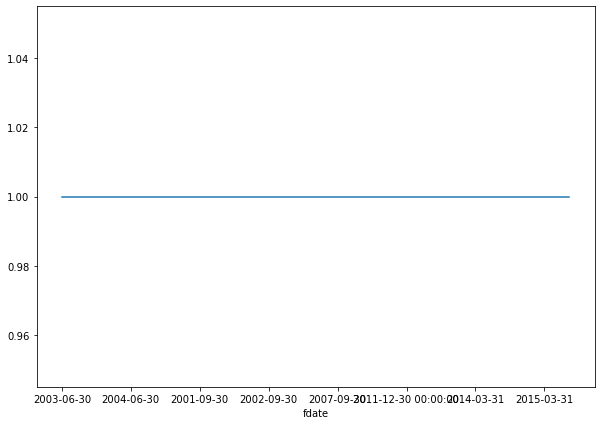

In [40]:
props.set_index('fdate').sum(axis=1).plot(figsize=(10,7))

# What is the average market beta, market cap, volatility of Ackman’s portfolio versus the average investor over the same time period? 

#### Ackman’s portfolio

In [27]:
query = """SELECT 
               `names_`.`year`,
               sum(shares * mcap) / sum(shares) AS avg_mcap,
               sum(shares * beta_mktrf) / sum(shares) AS avg_beta,
               sum(shares * volatility) / sum(shares) AS avg_volatility
            FROM
            (SELECT * from hw.hw1_stock_characteristics) AS nums
            INNER join
            (SELECT 
               a.`year` AS `year`, a.cusip, permno, shares
            FROM
               (select YEAR(fdate) AS `year`, cusip, shares from instown.file3 where mgrno=%s) a
               INNER JOIN 
               (select namedt, cusip, permno from crsp.dsenames) b
               ON a.cusip=b.cusip) `names_`
            ON `names_`.`year`=nums.`year` AND `names_`.permno=nums.permno
            GROUP BY `year` ORDER BY `year`""" % mgrno.iloc[0, 0]
ackman = mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 0.1349174976348877 seconds


#### Average investor's portfolio, assume he/she invested according to table "hw1_stock_characteristics" from database "hw".

In [28]:
query = """SELECT 
              `year`,
              AVG(mcap) AS avg_mcap,
              AVG(beta_mktrf) AS avg_beta,
              AVG(volatility) AS avg_volatility 
           FROM hw.hw1_stock_characteristics GROUP BY `year`;"""
avg_ivtor = mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 0.10096883773803711 seconds


#### Outperformance/Underperformance of Ackman's portfolio compared with average investor's portfolio
#### Measured by: performance metric of Ackman's portfolio - performance metric of average investor's portfolio.

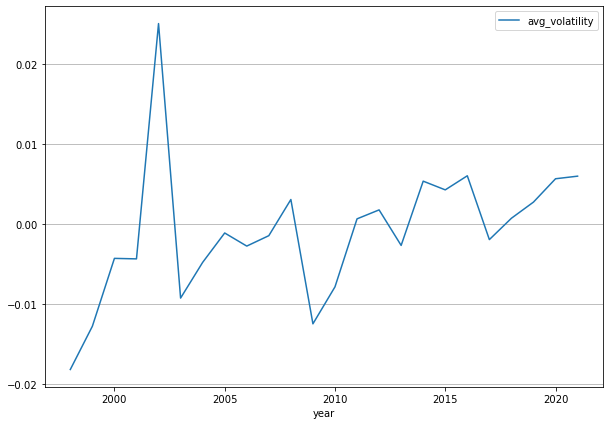

In [40]:
cmp = ackman.set_index('year').sort_index().subtract(avg_ivtor.set_index('year').sort_index()).dropna()
cmp.plot(y=['avg_volatility'], figsize=(10,7)).grid(axis='y')

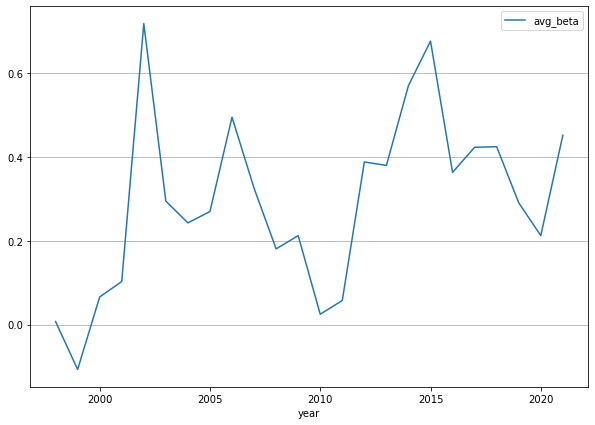

In [41]:
cmp.plot(y=['avg_beta'], figsize=(10,7)).grid(axis='y')

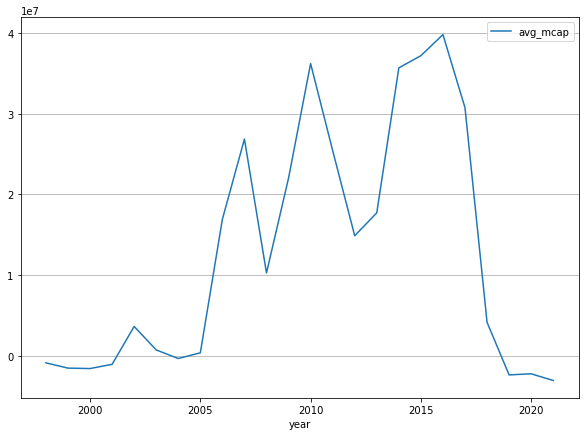

In [42]:
cmp.plot(y=['avg_mcap'], figsize=(10,7)).grid(axis='y')

# Plot Bill Ackman’s fund-level AUM over time using data assuming that the end of quarter price from crsp.msf (you’ll notice that instown.file2 has some weird price data), and the shares in instown in file3 

In [43]:
query = """SELECT 
               b.date, sum(a.shares*b.prc) as aum 
            FROM
               (SELECT fdate, cusip, shares from instown.file3 WHERE mgrno=%s) a
               INNER JOIN 
               (SELECT cusip, DATE, prc from crsp.msf) b 
               ON (a.cusip=b.cusip AND a.fdate=b.date)
            GROUP BY DATE ORDER BY date""" % mgrno.iloc[0, 0]
aum = mysql_query(query,user=user,password=password,port=3306) # Apache Doris

Elapsed time: 35.890512466430664 seconds


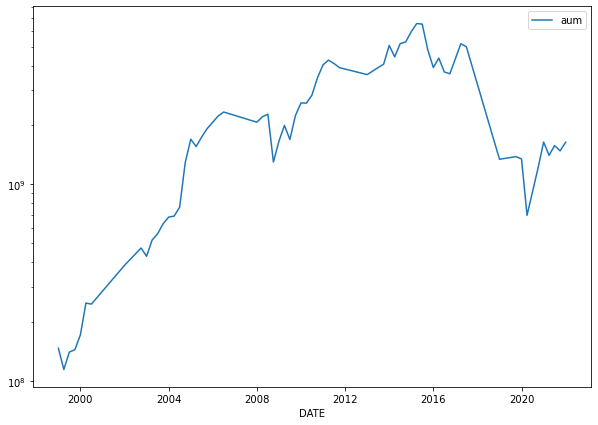

In [44]:
aum.plot(x='DATE', y='aum', figsize=(10,7), logy=True)

# Extra credit (2 points): Assuming that Bill Ackman only trades on the last day of the quarter end (thus, holding the stock to the end of the next quarter in full), calculate his portfolio return. Calculate the cumulative P&L curve of Bill Ackman.

In [45]:
query = """SELECT
              fdate, sum(shares * ret) AS shares_ret
           from
              (SELECT 
           	   a.fdate, a.cusip, a.shares, b.ret
              from
                 (SELECT fdate, cusip, shares FROM instown.file3 WHERE mgrno=%s) a
                 INNER JOIN
                 (SELECT DATE(`date`) AS `date`, cusip, ret FROM crsp.msf WHERE ret IS NOT null) b
              	ON a.fdate=b.`date`) j
           GROUP BY fdate;""" % mgrno.iloc[0, 0]
pnl = mysql_query(query,user=user,password=password,port=19030) # Apache Doris

Elapsed time: 0.09238767623901367 seconds


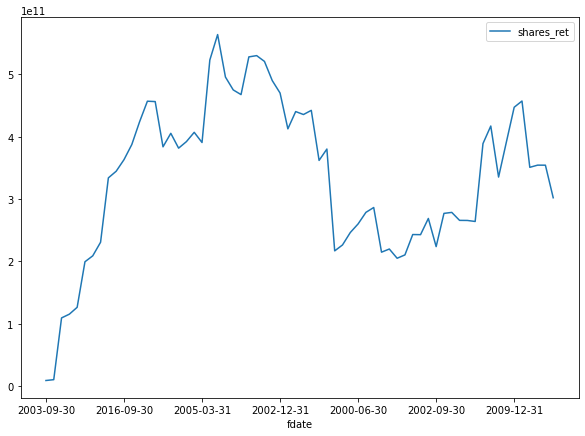

In [51]:
pnl.set_index('fdate').cumsum().plot(figsize=(10,7))